# Nettoyage des données
Created by: Thomas Durand-Texte, Jan. 2023

# Import des packages

In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option("display.max_columns", 200)
import missingno as msno

import datetime as dt
import scipy.stats as st


import matplotlib.pyplot as plt
import seaborn as sns

cm = 1./2.54


# Paramètres graphiques et fonctions utiles

In [49]:
import os
import subprocess

white_font = True

def set_theme():
    if white_font: wht, grey, blck = '0.84' , '0.5', 'k'
    else: wht, grey, blck = 'k', '0.5', '0.84'
    rc = { 'figure.facecolor':(0.118,)*3, 
            'axes.labelcolor':wht,
            'axes.edgecolor':wht,
            'axes.facecolor':(0,0,0,0),
            'text.color':'white',
            'text.usetex':False,
            'text.latex.preamble':r'\usepackage[cm]{sfmath} \usepackage{amsmath}' ,
            'font.family': 'sans-serif' ,
            'font.sans-serif': 'cm' ,
            'xtick.color':wht,
            'ytick.color':wht,
            "axes.grid" : True,
            "grid.color": (0.7,)*3,
            "grid.linewidth": 0.4,
            "grid.linestyle": (10,5),
            'legend.edgecolor':'0.2',
            'legend.facecolor':(0.2,0.2,0.2,0.6),
            # 'legend.framealpha':'0.6',
            'pdf.fonttype':42,
            'savefig.format':'pdf',
            'savefig.transparent':True }
 
    sns.set_theme( 'notebook' , rc=rc )

def make_folder( path_folder ):
    path_folder = path_folder.__str__()
    try:
        if os.path.isdir( path_folder ) : return
        os.makedirs(path_folder)
    except OSError:
        pass
    return

def concat_folders(*args, **kwargs):
    """ concat_folders(*args, **kwargs)
        concatenate folders in args (strings) """
    sPath = ''
    for arg in args:
        if arg == '..': sPath = sPath[:sPath[:-1].rfind(os.sep)+1]
        else: sPath += arg
        if sPath[-1] != os.sep: sPath += os.sep
    return sPath

class Path(object):
    """ Path( s_in='', s_lim=None)
        create a path to the string s_in (default is current path)
        and stops after s_lim """
    n_Path = 0
    def __init__(self, s_in='', s_lim=None):
        """docstring."""
        if s_in == '': s_in = os.getcwd()
        if not s_lim is None:
            if s_lim in s_in:
                s_in = s_in[ :s_in.index( s_lim ) + len(s_lim) ]
        self.sPath = concat_folders(s_in)
        self.N = Path.n_Path
        Path.n_Path += 1

    def __add__(self, other):
        """ Path + str : return str """
        if isinstance(other, str): return self.sPath + other

    def __truediv__(self, other):
        """ Path / str : return path concatenated"""
        if isinstance(other, str): return Path(concat_folders(self.sPath, other))

    def __invert__(self):
        """ ~Path : return str of the path """
        return self.sPath

    def __str__(self):
        """ __str__ return str of the path """
        return self.sPath
    # __str__ #

    def makedir( self ):
        return make_folder( self )


def gs_opt( filename ):
    """ otpimisation of a pdf file with gosthscript """
    filenameTmp = filename.replace('.pdf', '') + '_tmp.pdf'
    gs = ['gs',
            '-sDEVICE=pdfwrite',
            '-dEmbedAllFonts=true',
            '-dSubsetFonts=true',             # Create font subsets (default)
            '-dPDFSETTINGS=/prepress',        # Image resolution
            '-dDetectDuplicateImages=true',   # Embeds images used multiple times only once
            '-dCompressFonts=true',           # Compress fonts in the output (default)
            '-dNOPAUSE',                      # No pause after each image
            '-dQUIET',                        # Suppress output
            '-dBATCH',                        # Automatically exit
            '-sOutputFile='+filenameTmp,      # Save to temporary output
            filename]                         # Input file

    subprocess.run(gs)                                      # Create temporary file
    subprocess.run( 'rm -f ' + filename, shell=True)            # Delete input file
    subprocess.run( 'mv -f ' + filenameTmp + " " + filename, shell=True) # Rename temporary to input file

def savefig( fig, savename, **kwargs ):
    """ savefig( fig, savename, **kwargs ) 
        Saves a figure with kwargs (fig.savefig( savename, **kwargs) ).
        A check is done first to determine if a folder has to be created according to savename.
        Finally, if the file is saved as .pdf, gosthscript optimisation is performed. """
    if os.sep in savename: make_folder( savename[:savename.rindex(os.sep)] )
    fig.savefig( savename, **kwargs )
    savename += '.pdf'
    if os.path.isfile( savename ): gs_opt( savename )


set_theme()
del set_theme

if False: # Plot a figure
    x = np.linspace( 0, 10, 100 )
    y = np.sin( x )

    fig, ax = plt.subplots( figsize=(15*cm,12*cm) )
    ax.plot( x, y, 'r', label='sine' )
    ax.legend()
    plt.show()

# Lecture des premières lignes pour vérifier le format

In [3]:
with open('openfood_OC.csv' , 'r') as file:
    line = file.readline()
    print('n \\t: {:}'.format( len(line.split('\t')) ) )
    print(line)
    # print(file.readline())
    # print(file.readline())

n \t: 191
code	url	creator	created_t	created_datetime	last_modified_t	last_modified_datetime	product_name	abbreviated_product_name	generic_name	quantity	packaging	packaging_tags	packaging_en	packaging_text	brands	brands_tags	categories	categories_tags	categories_en	origins	origins_tags	origins_en	manufacturing_places	manufacturing_places_tags	labels	labels_tags	labels_en	emb_codes	emb_codes_tags	first_packaging_code_geo	cities	cities_tags	purchase_places	stores	countries	countries_tags	countries_en	ingredients_text	allergens	allergens_en	traces	traces_tags	traces_en	serving_size	serving_quantity	no_nutriments	additives_n	additives	additives_tags	additives_en	ingredients_from_palm_oil_n	ingredients_from_palm_oil	ingredients_from_palm_oil_tags	ingredients_that_may_be_from_palm_oil_n	ingredients_that_may_be_from_palm_oil	ingredients_that_may_be_from_palm_oil_tags	nutriscore_score	nutriscore_grade	nova_group	pnns_groups_1	pnns_groups_2	food_groups	food_groups_tags	food_groups_en	states	sta

# chargement des données

In [4]:
dtype = { 'additives': 'object' , 'abbreviated_product_name': 'object', 'allergens': 'object', 'cities_tags': 'object', 'code': 'object', 'ecoscore_grade_fr': 'object', 'emb_codes': 'object', 'emb_codes_tags': 'object', 'first_packaging_code_geo': 'object', 'food_groups': 'object', 'food_groups_en': 'object', 'food_groups_tags': 'object', 'generic_name': 'object', 'ingredients_from_palm_oil_tags': 'object', 'ingredients_that_may_be_from_palm_oil_tags': 'object', 'manufacturing_places': 'object', 'manufacturing_places_tags': 'object', 'origins': 'object', 'origins_en': 'object', 'origins_tags': 'object', 'packaging_text': 'object', 'purchase_places': 'object', 'traces': 'object', 'traces_en': 'object', 'traces_tags': 'object'}
data = dd.read_csv('openfood_OC.csv', delimiter ='\t', dtype=dtype)
data = data.compute()

# data = pd.read_csv('openfood_OC.csv', delimiter='\t', dtype=dtype)
data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_en,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,food_groups,food_groups_tags,food_groups_en,states,states_tags,states_en,brand_owner,ecoscore_score_fr,ecoscore_grade_fr,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,soluble-fiber_100g,insoluble-fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0729950200110,http://world-en.openfoodfacts.org/product/0729...,usda-ndb-import,1489137181,2017-03-10T09:13:01Z,1637334604,2021-11-19T15:10:04Z,Plantain Chips,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Top Banana,top-banana,"Plantain chips, Chips","en:chips,en:plantain-chips","Chips,Plantain-chips",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States,en:united-states,United States,"Plantains, vegetable oil (cotton seed oil and/...",NaN,NaN,NaN,NaN,NaN,28 g (32 CHIPS) | (ABOUT),28.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,11.0,d,3.0,unknown,unknown,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",NaN,NaN,NaN,en:plantain-chips,P

# Visiualisation of NaN with missingno
as barplot 

<AxesSubplot: >

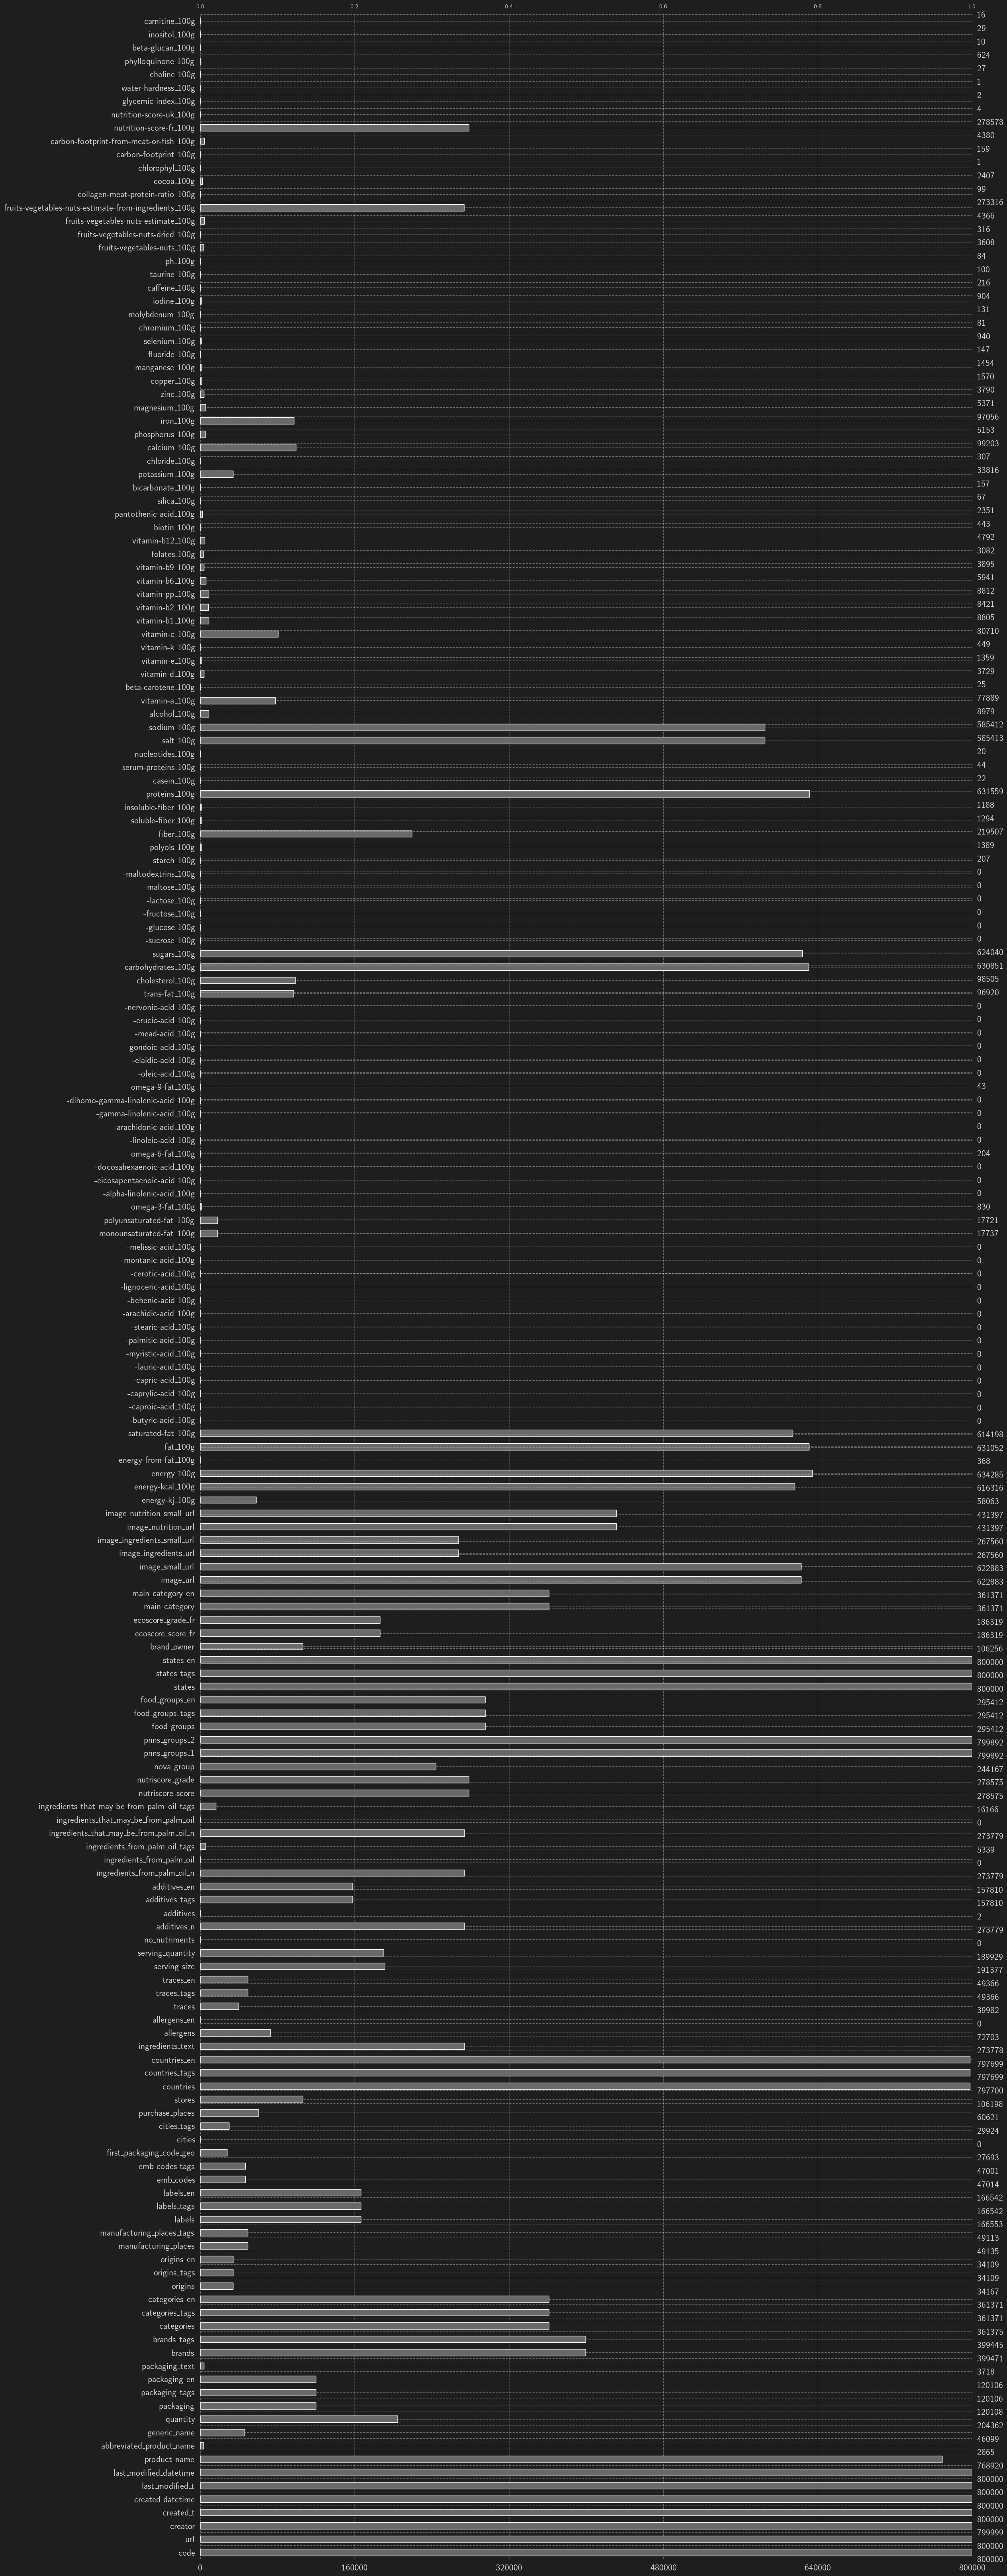

In [5]:
msno.bar( data )

# remove empty and some usused/unusable? columns

In [6]:
n = len(data) # number of samples
sum_isnull = data.isnull().sum() # number of null data for each column

In [7]:
def remove_categories_to_kept( lst_categories_to_remove ):
    kept_keys = ['origins', 'brands', 'labels', 'allergens', 'additives', 'palm']
    lst_out = []
    for cat in lst_categories_to_remove:
        not_to_add = False
        for key in kept_keys: 
            if key in cat:
                not_to_add = True
                break
        if not_to_add: continue
        lst_out.append( cat ) 
    return lst_out

categories_full = sum_isnull[ sum_isnull == 0].index.to_list()
categories_empty = sum_isnull[ sum_isnull > int(0.9*n)].index.to_list()

print('emtpy categories:', categories_empty)
other_removed_cat = [key for key in data.keys() if 'image' in key] # remove the images
other_removed_cat.append( 'url' )
print('\nother removed categories:', other_removed_cat )

removed_cat = remove_categories_to_kept( categories_empty + other_removed_cat )

# check is completely empty categories remains
removed_cat += [ key for key in sum_isnull[ sum_isnull == n].index.to_list() if not key in removed_cat ]

# check if key are still in DataFrame
current_categories = data.keys()
removed_cat = [key for key in removed_cat if key in current_categories]

if True: data.drop( columns=removed_cat, inplace=True )
# msno.bar( data )

emtpy categories: ['abbreviated_product_name', 'generic_name', 'packaging_text', 'origins', 'origins_tags', 'origins_en', 'manufacturing_places', 'manufacturing_places_tags', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'allergens', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'no_nutriments', 'additives', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'energy-kj_100g', 'energy-from-fat_100g', '-butyric-acid_100g', '-caproic-acid_100g', '-caprylic-acid_100g', '-capric-acid_100g', '-lauric-acid_100g', '-myristic-acid_100g', '-palmitic-acid_100g', '-stearic-acid_100g', '-arachidic-acid_100g', '-behenic-acid_100g', '-lignoceric-acid_100g', '-cerotic-acid_100g', '-montanic-acid_100g', '-melissic-acid_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g', '-alpha-linolenic-acid_100g', '-eicosapen

# Visualisation of NaN for new DataFrame

<AxesSubplot: >

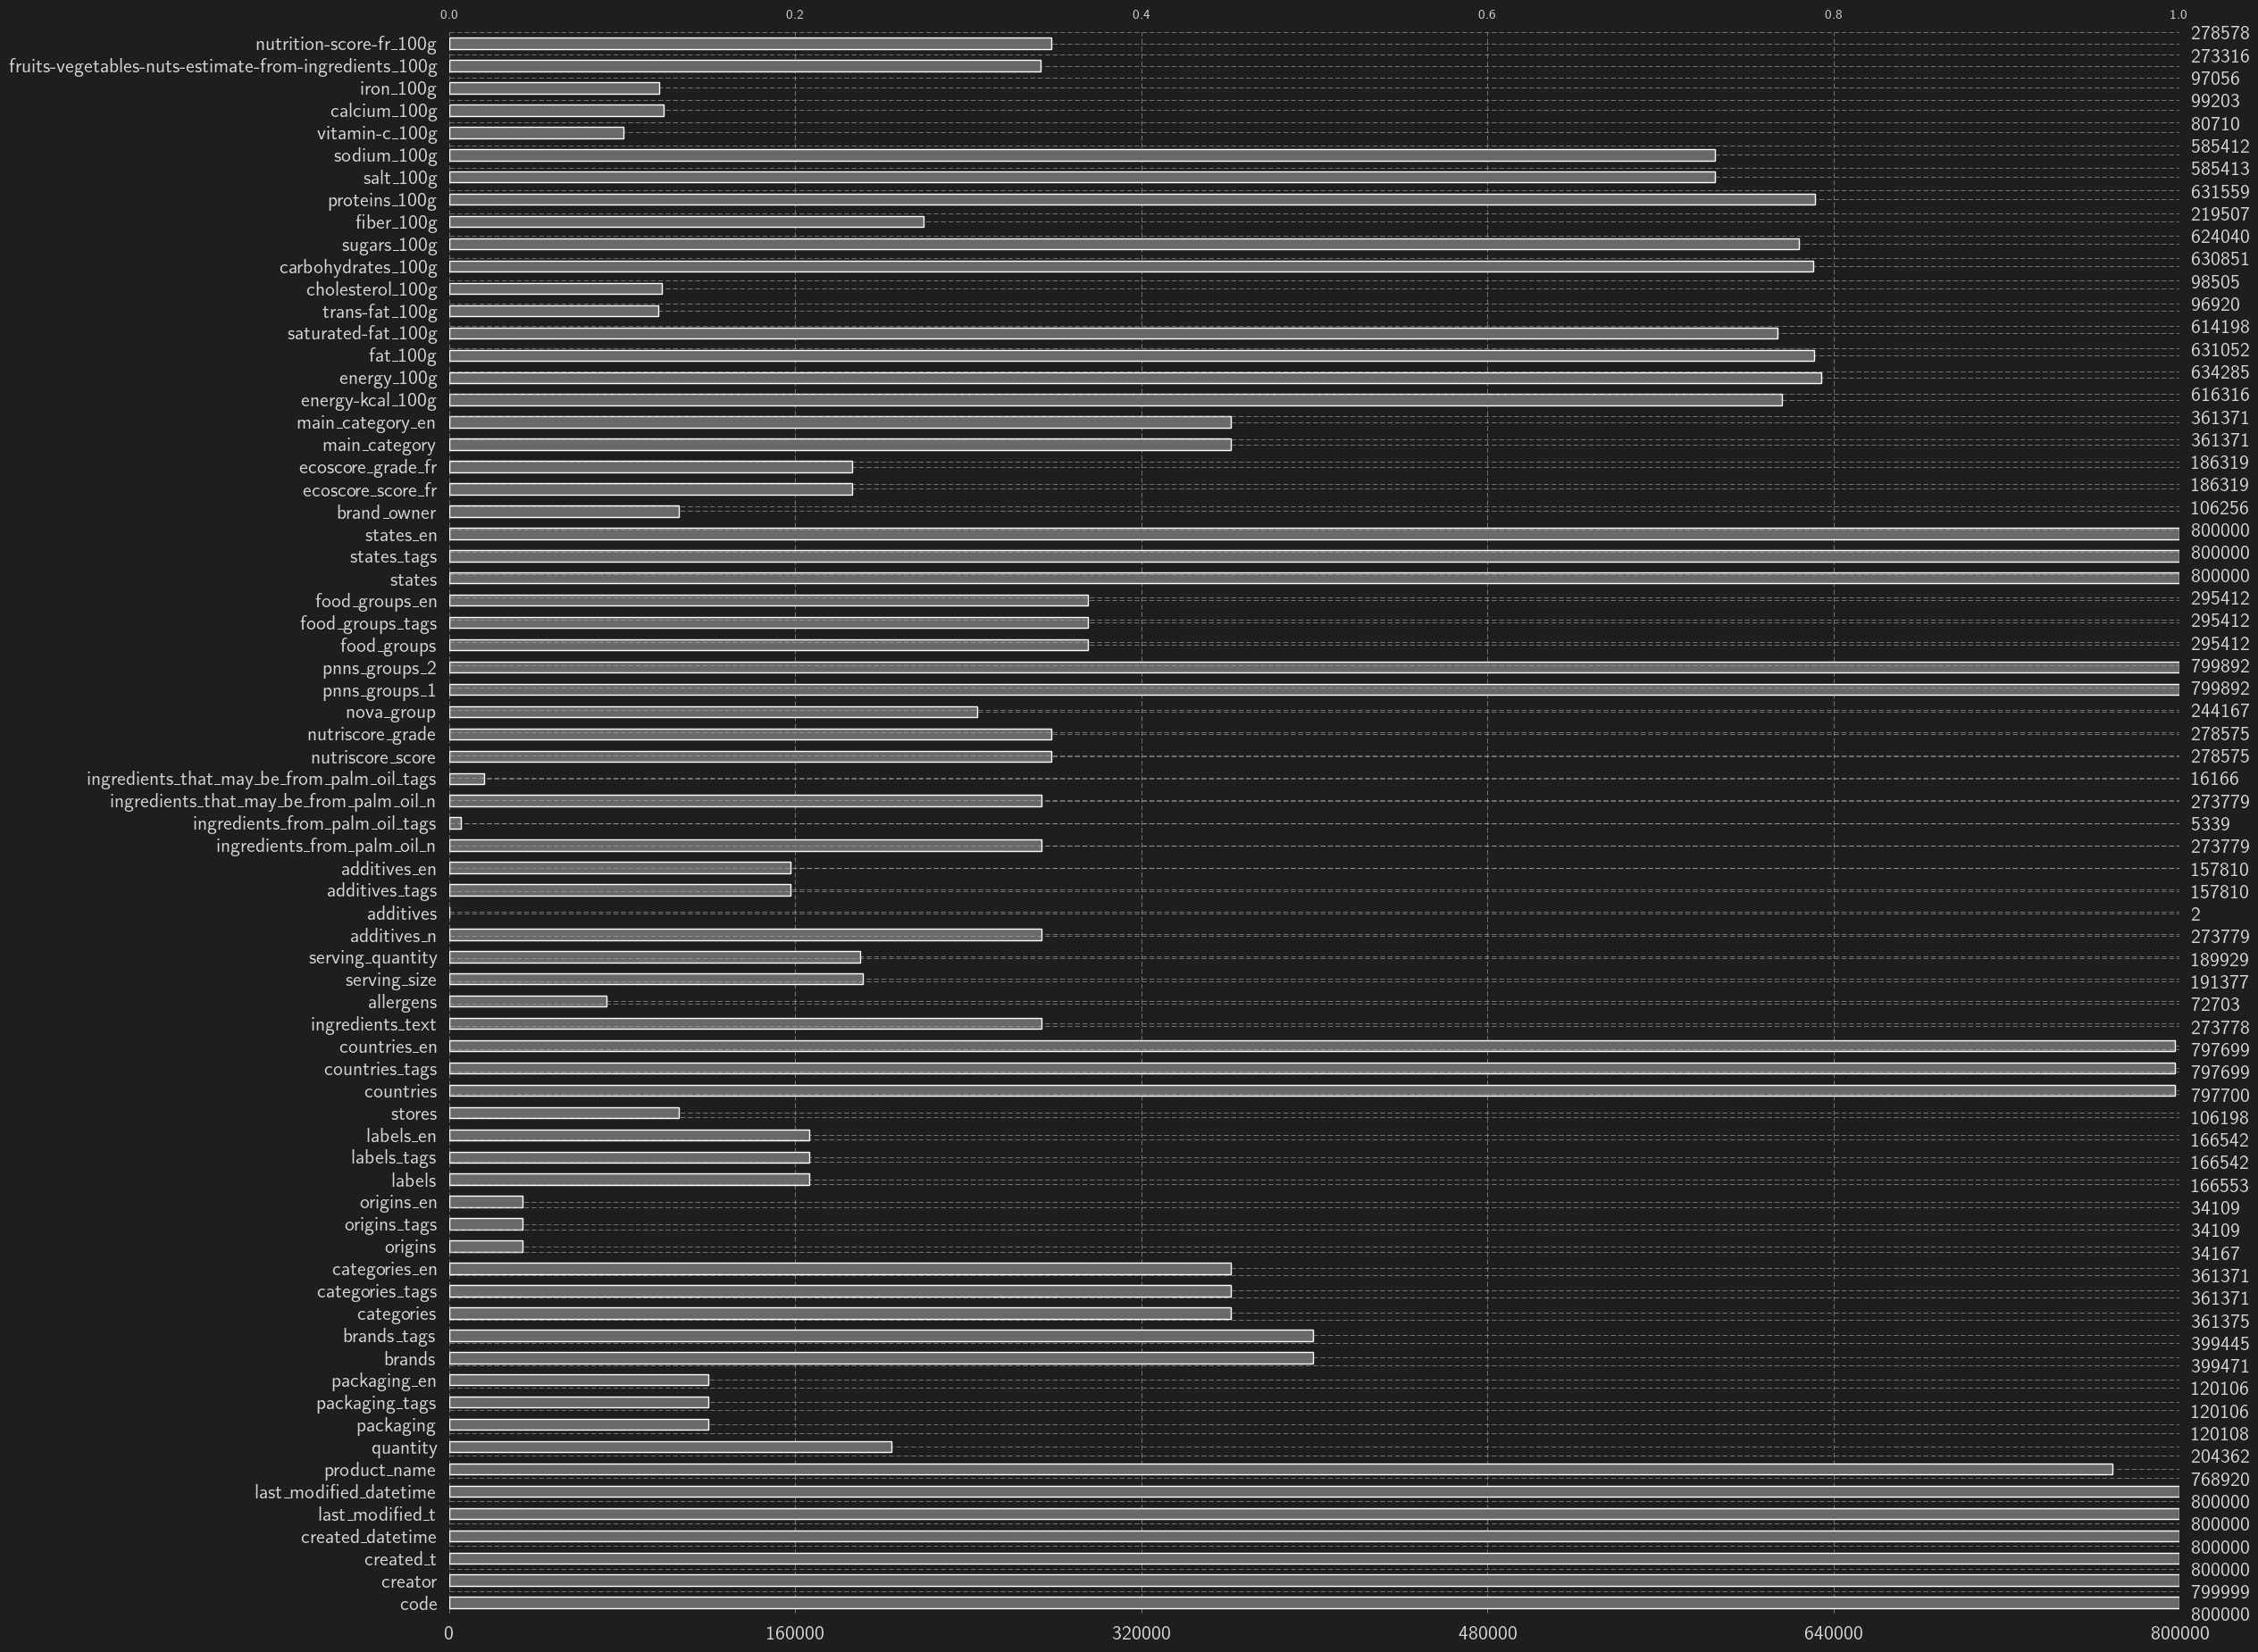

In [8]:
msno.bar( data )

# Heatmap without fully filled categories

<AxesSubplot: >

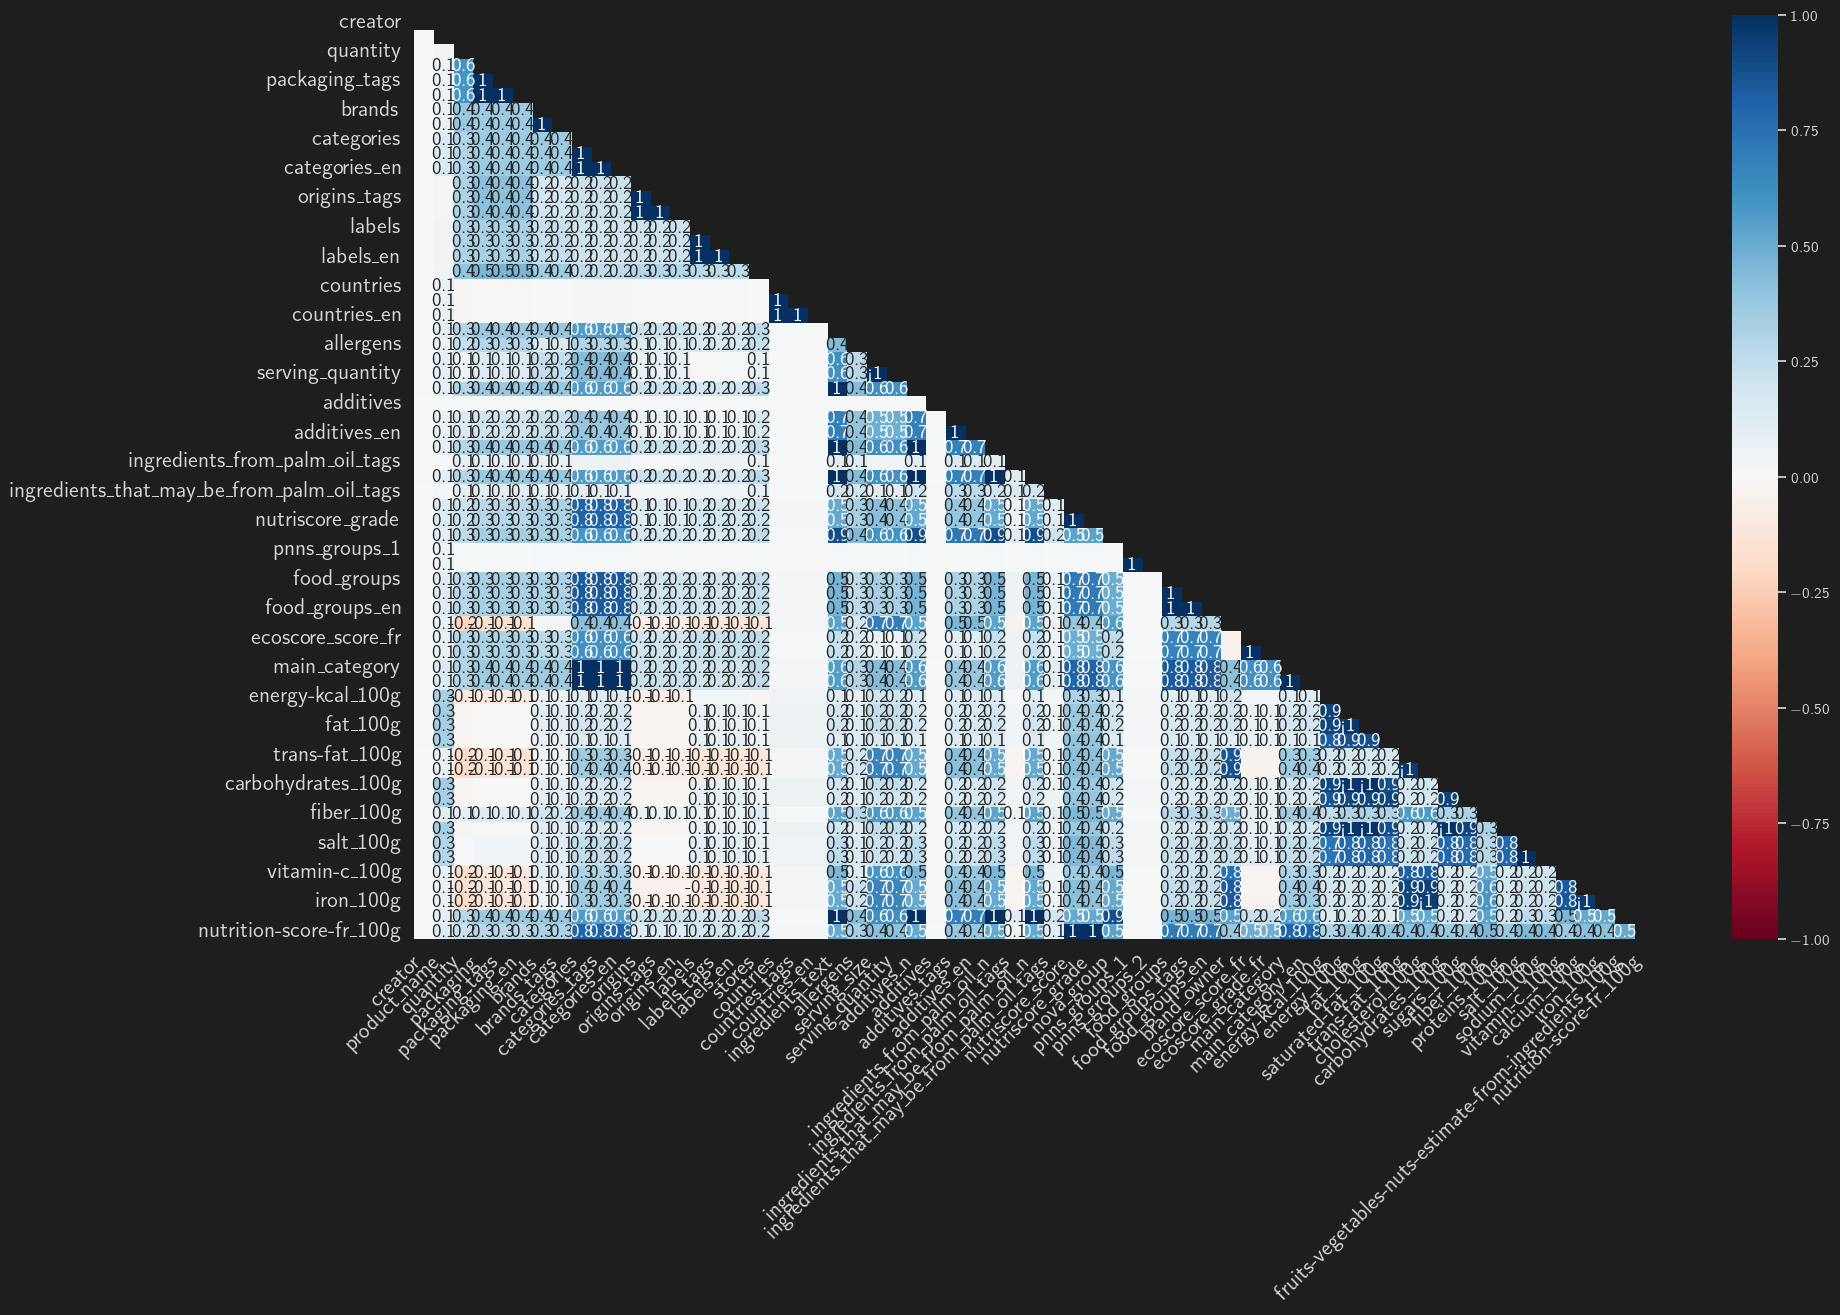

In [9]:
msno.heatmap( data[ [key for key in data.keys() if (not key in categories_full)] ] )

# Heatmap without fully filled categories (qualitatives + nutriscore)

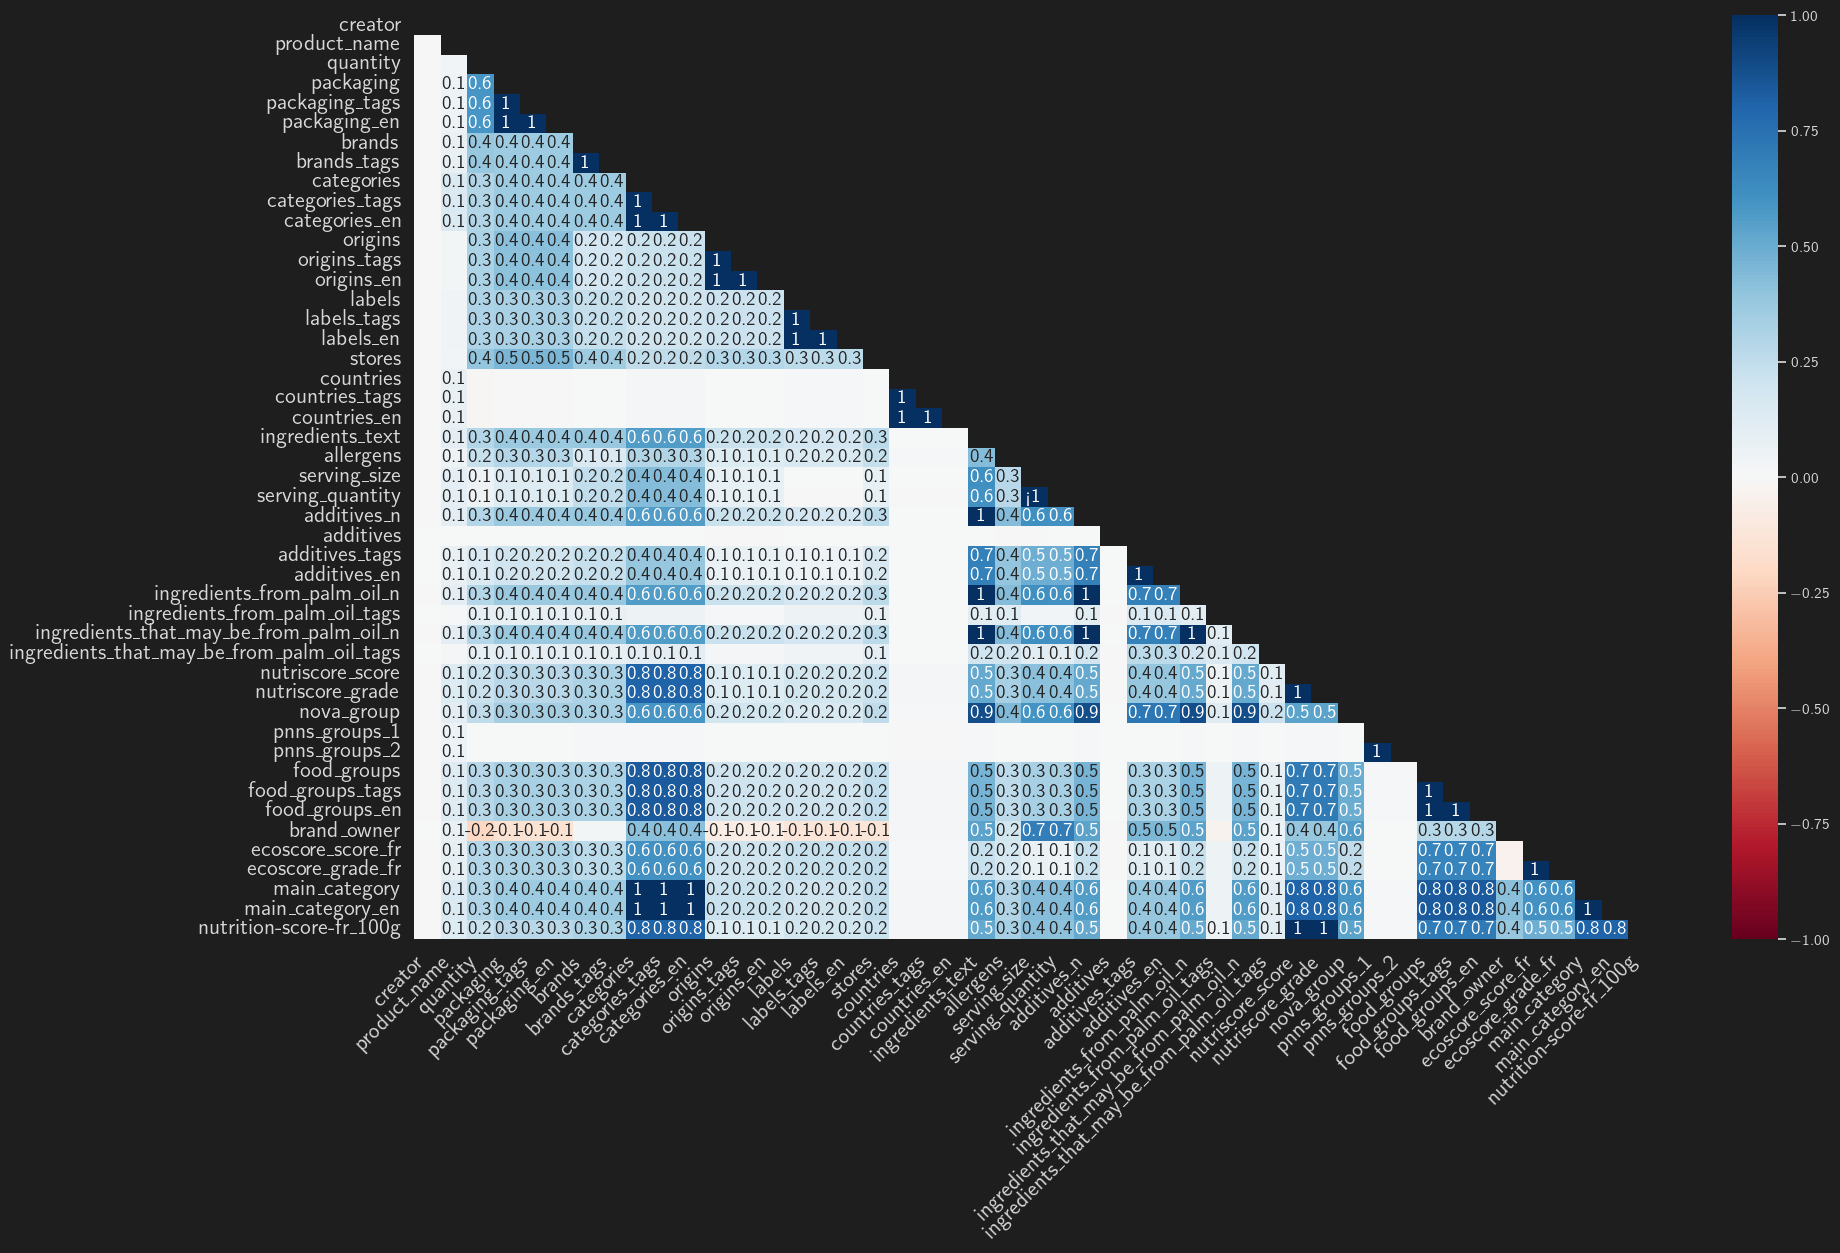

In [10]:
ax = msno.heatmap( data[ [key for key in data.keys() if (not key in categories_full) and (not '_100g' in key) or 'score' in key] ] )

# DTYPES

In [11]:
with pd.option_context('display.max_rows', None):
    display(data.dtypes)

code                                                      object
creator                                                   object
created_t                                                  int64
created_datetime                                          object
last_modified_t                                            int64
last_modified_datetime                                    object
product_name                                              object
quantity                                                  object
packaging                                                 object
packaging_tags                                            object
packaging_en                                              object
brands                                                    object
brands_tags                                               object
categories                                                object
categories_tags                                           object
categories_en            

# Séparation en deux DataFrames: objects / flaot64

In [12]:
categories_float, categories_others = [], []
for cat in data.keys():
    if data.dtypes[cat] == 'float64': categories_float.append( cat )
    else: categories_others.append( cat )
print("float categories:", categories_float )
print("\nothers categories:", categories_others )

categories_string = []
print('\nstrings to lowercase')
for key in categories_others: 
    print(key, 'type', data[key].dtype)
    if data[key].dtype != 'object': continue
    categories_string.append( key )
    data[key].str.lower()

float categories: ['serving_quantity', 'additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score', 'nova_group', 'ecoscore_score_fr', 'energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'nutrition-score-fr_100g']

others categories: ['code', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'quantity', 'packaging', 'packaging_tags', 'packaging_en', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_en', 'origins', 'origins_tags', 'origins_en', 'labels', 'labels_tags', 'labels_en', 'stores', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'allergens', 'serving_size', 'additives', 'additives_tags',

# Analyse variables string

In [ ]:
dico_value_counts = { key:data[key].value_counts(normalize=True) for key in categories_string }

,code,creator,created_datetime,last_modified_datetime,product_name,quantity,packaging,packaging_tags,packaging_en,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,labels,labels_tags,labels_en,stores,countries,countries_tags,countries_en,ingredients_text,allergens,serving_size,additives,additives_tags,additives_en,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_tags,nutriscore_grade,pnns_groups_1,pnns_groups_2,food_groups,food_groups_tags,food_groups_en,states,states_tags,states_en,brand_owner,ecoscore_grade_fr,main_category,main_category_en
0,799996,8792,742349,654623,555455,18867,20225,17995,17984,98093,78982,64744,38134,38131,6418,5240,5224,37997,28372,28365,8029,6459,2493,2493,244293,3279,25683,2,48883,48883,13,226,5,11,41,46,46,46,3542,3542,3542,15559,5,18849,18847


min counts 2


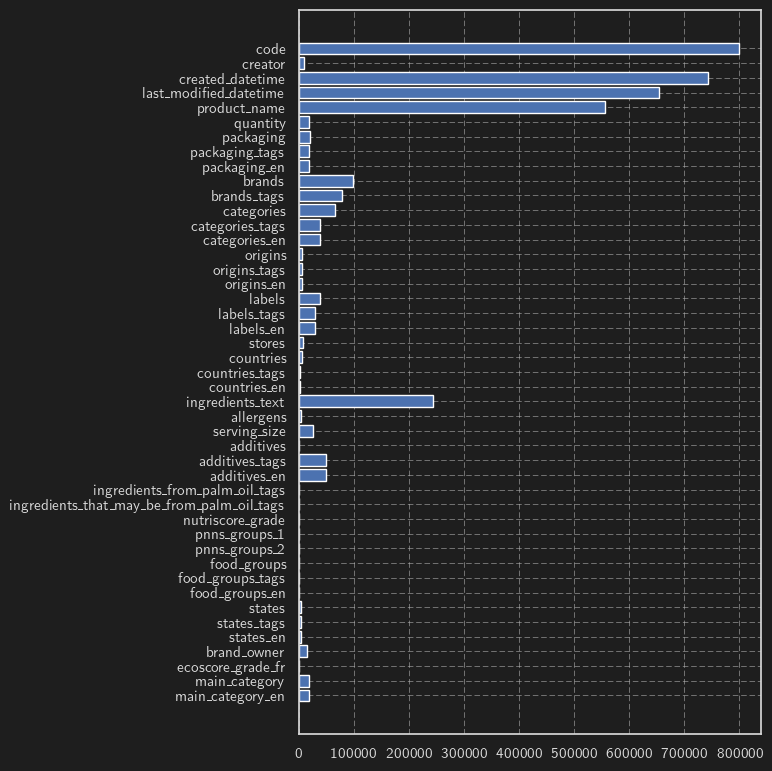

In [25]:
data_value_counts = pd.DataFrame( {key:[len(dico_value_counts[key])] for key in categories_string} )
display(data_value_counts)
# data_value_counts.plot( kind='bar' )

print('min counts', data_value_counts.iloc[0,:].min() )

y_pos = np.arange( len(categories_string) )
fig, ax = plt.subplots( figsize=(20*cm,20*cm))
ax.barh( y_pos, data_value_counts.iloc[0,:] , align='center')
ax.set_yticks(y_pos, labels=categories_string)
ax.invert_yaxis()  # labels read top-to-bottom

fig.tight_layout()
del y_pos


In [33]:
key = 'labels'
print( '\nName: {:}, len {:}\n'.format( key, len(dico_value_counts[key]) ), dico_value_counts[key])


Name: labels, len 37997
 Bio                                                                                 0.048807
en:gluten-free                                                                      0.041861
Organic                                                                             0.041536
Fabriqué en France                                                                  0.020996
Point Vert                                                                          0.019495
                                                                                      ...   
Ecológico,Vegetariano,Vegano,Sin glutamato                                          0.000006
100% Rindfleisch                                                                    0.000006
high fibre                                                                          0.000006
Nutriscore,Triman                                                                   0.000006
Déconseillé à certaines catégories de person

findfont: Generic family 'sans-serif' not found because none of the following families were found: cm


Name: pnns_groups_1, len 11
Name: pnns_groups_2, len 41
Name: food_groups, len 46
Name: food_groups_en, len 46


findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following fami

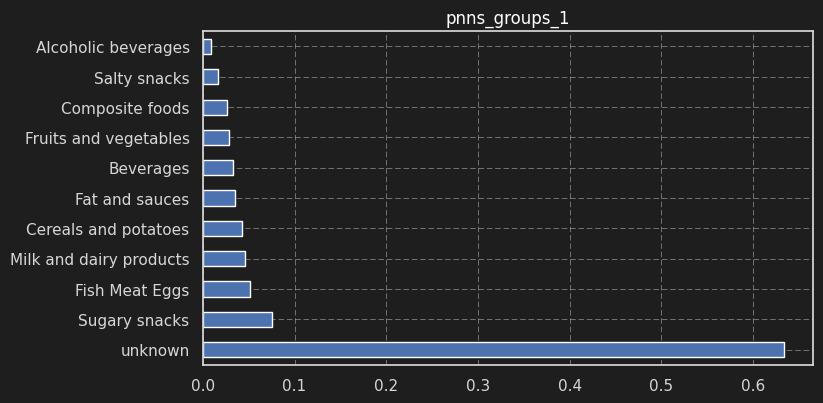

findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following fami

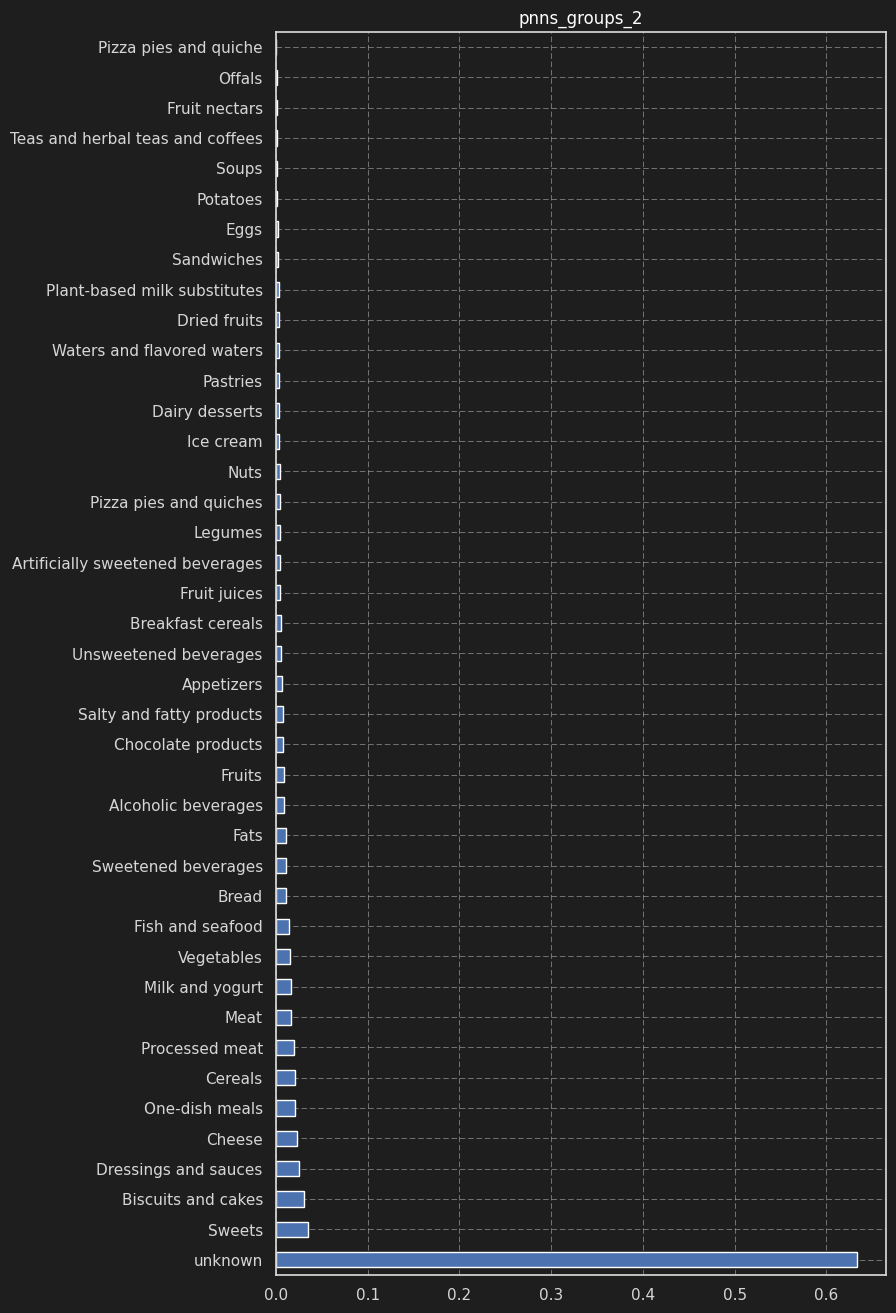

findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following fami

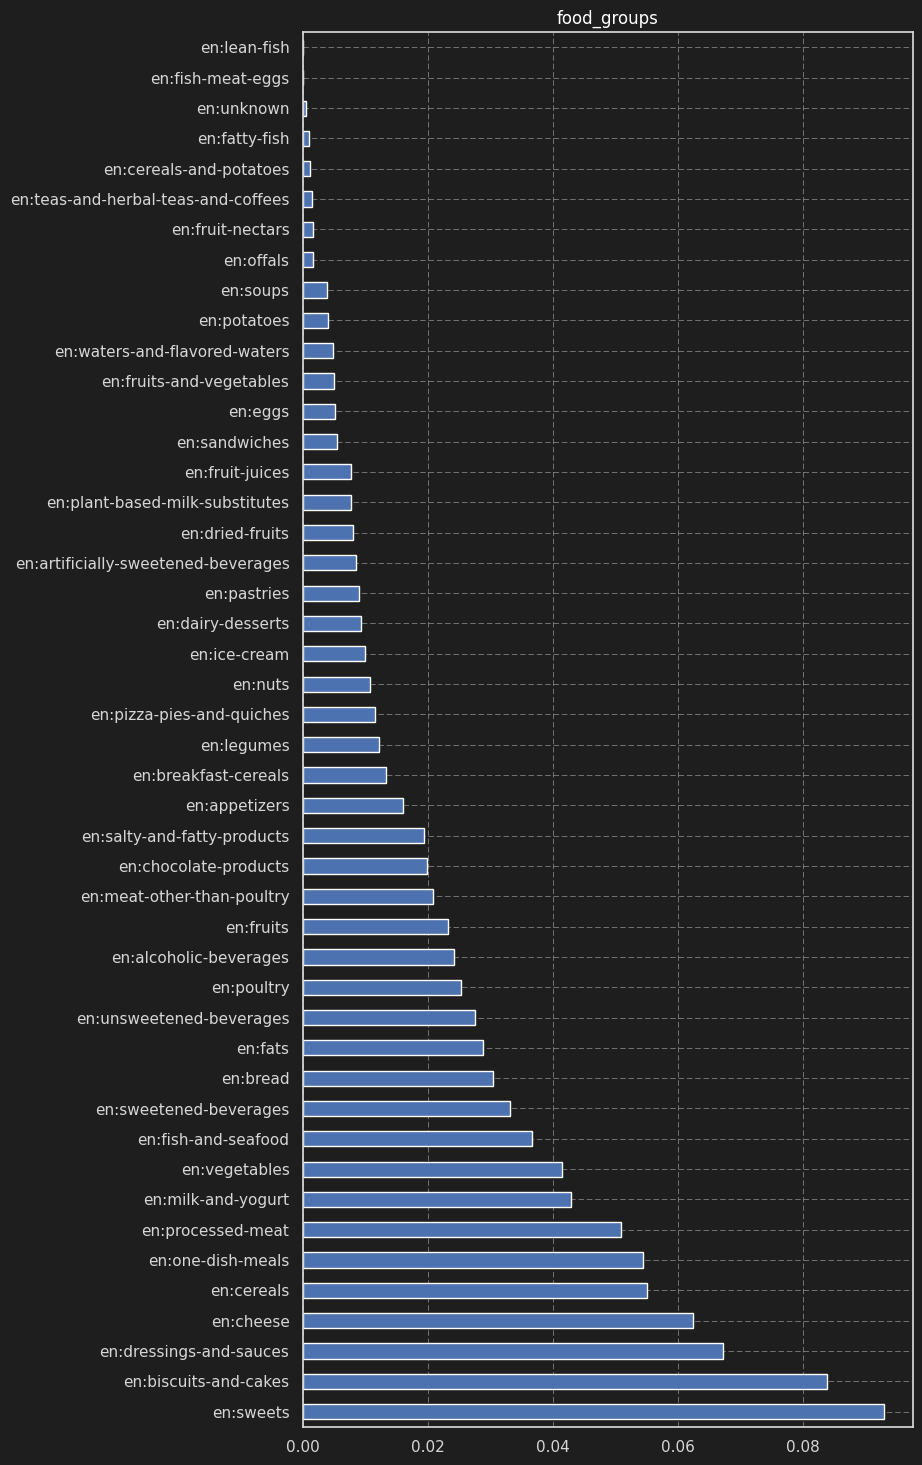

findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Generic family 'sans-serif' not found because none of the following fami

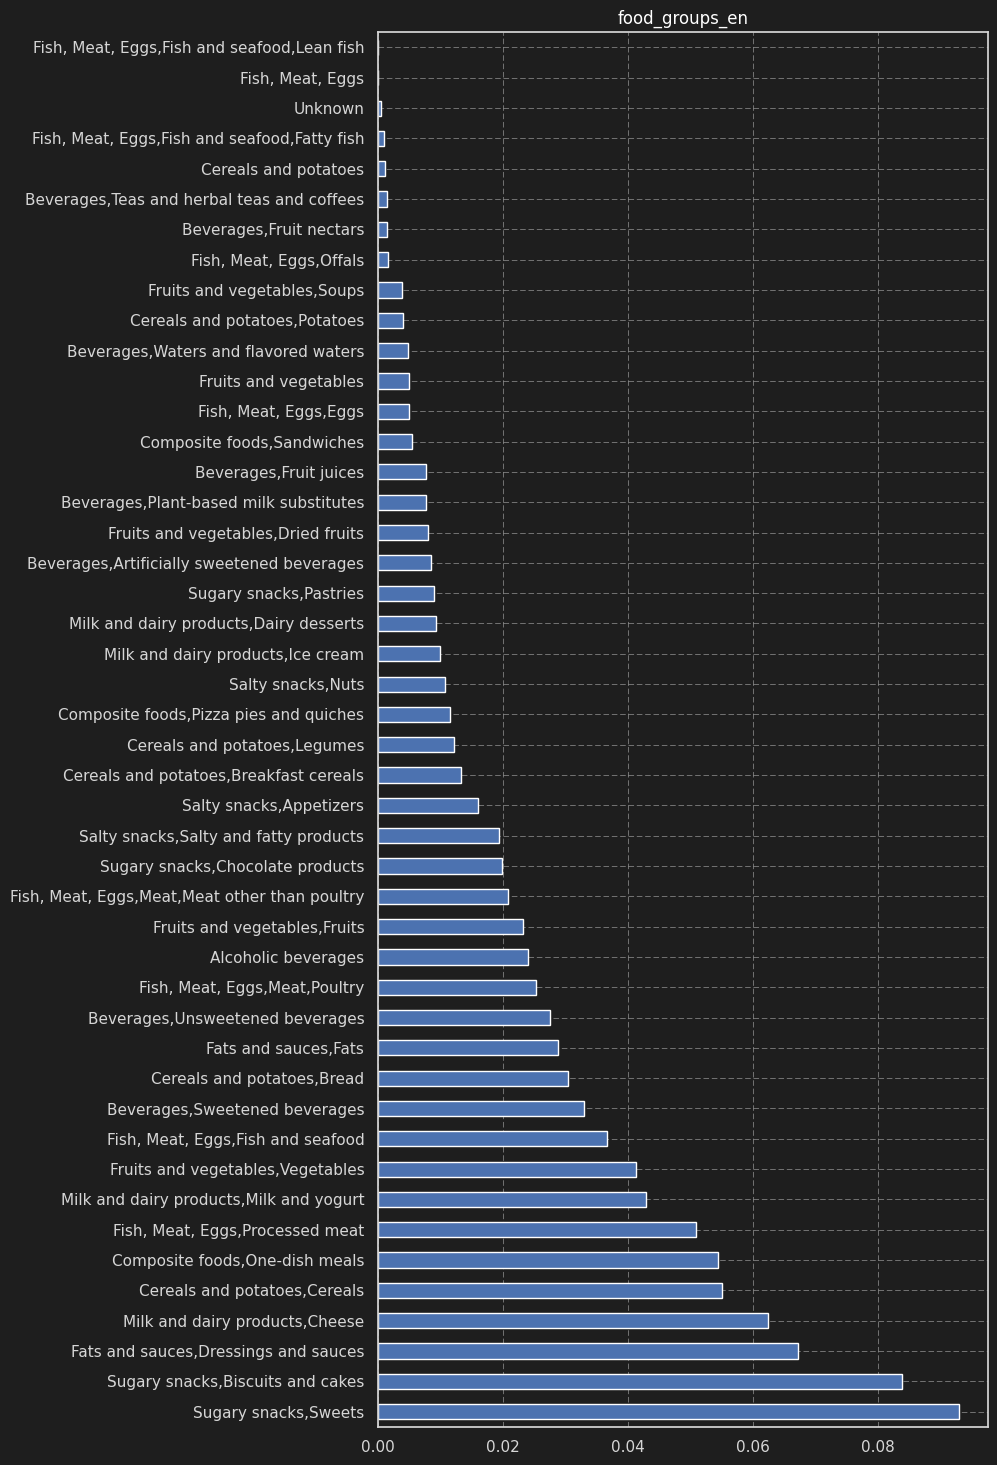

In [50]:
categories_to_plot = [ 'pnns_groups_1', 'pnns_groups_2', 'food_groups', 'food_groups_en']
#categories_to_plot = categories_to_plot[-1:]



for key in categories_to_plot:
    # print( '\nName: {:}, len {:}\n'.format( key, len(dico_value_counts[key]) ), dico_value_counts[key])
    print( 'Name: {:}, len {:}'.format( key, len(dico_value_counts[key]) ) )

    fig, ax = plt.subplots( figsize=(20*cm, 10*cm*len(dico_value_counts[key])/10) )
    dico_value_counts[key].plot( kind="barh", ax=ax )
    ax.set_title(key)
    # if '_2' in key: break




# # Diagramme en secteurs
# data[key].value_counts(normalize=True).plot(kind='pie')
# # Cette ligne assure que le pie chart est un cercle plutôt qu'une éllipse
# plt.axis('equal') 
# plt.show() # Affiche le graphique

# # Diagramme en tuyaux d'orgues
# data[key].value_counts(normalize=True).plot(kind='bar')
# plt.show()

# Analyse variables float

In [15]:
data[categories_float].describe()

,serving_quantity,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,nova_group,ecoscore_score_fr,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-c_100g,calcium_100g,iron_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
count,1.899290e+05,273779.000000,273779.000000,273779.000000,278575.000000,244167.000000,186319.000000,6.163160e+05,6.342850e+05,6.310520e+05,6.141980e+05,96920.000000,98505.000000,6.308510e+05,6.240400e+05,2.195070e+05,6.315590e+05,5.854130e+05,5.854120e+05,80710.000000,9.920300e+04,97056.000000,273316.000000,278578.000000
mean,4.541139e+07,2.019019,0.019750,0.069965,9.121296,3.397445,43.360366,1.765230e+08,1.050878e+37,1.744705e+08,1.627096e+05,0.122302,0.056417,1.584378e+05,1.604063e+08,4.552631e+05,1.582406e+05,1.707070e+05,6.828290e+04,0.056126,2.016469e+03,0.008633,8.572664,9.121391
std,1.931123e+10,2.884767,0.140938,0.303732,8.848561,0.985914,25.769897,1.278597e+11,8.369400e+39,1.384715e+11,1.275127e+08,8.731580,1.567523,1.258185e+08,1.265884e+11,2.132964e+08,1.257479e+08,1.306100e+08,5.224406e+07,5.241345,6.349910e+05,0.450262,36.811276,8.848580
min,0.000000e+00,0.000000,0.000000,0.000000,-15.000000,1.000000,-30.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,-1.000000e+00,-2.000000e+01,-5.000000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,-0.000260,0.000000,-15.000000
25%,2.800000e+01,0.000000,0.000000,0.000000,1.000000,3.000000,27.000000,1.010000e+02,4.180000e+02,8.000000e-01,1.000000e-01,0.000000,0.000000,3.521127e+00,6.000000e-01,0.000000e+00,1.330000e+00,8.250000e-02,3.300000e-02,0.000000,0.000000e+00,0.000000,0.000000,1.000000
50%,5.500000e+01,1.000000,0.000000,0.000000,10.000000,4.000000,38.000000,2.600000e+02,1.080000e+03,7.000000e+00,1.800000e+00,0.000000,0.000000,1.540000e+01,3.570000e+00,1.600000e+00,6.000000e+00,5.875000e-01,2.350000e-01,0.000000,3.600000e-02,0.001000,0.000000,10.000000
75%,1.133981e+02,3.000000,0.000000,0.000000,16.000000,4.000000,65.000000,4.000000e+02,1.674000e+03,2.130000e+01,7.100000e+00,0.000000,0.022000,5.300000e+01,1.750000e+01,3.600000e+00,1.250000e+01,1.400000e+00,5.600000e-01,0.004000,1.100000e-01,0.002450,0.500000,16.000000
max,8.414808e+12,49.000000,3.000000,5.000000,40.000000,4.000000,125.000000,1.000000e+14,6.665559e+42,1.100000e+14,9.993273e+10,1666.000000,127.000000,9.993273e+10,1.000000e+14,9.993273e+10,9.993273e+10,9.993273e+10,3.997309e+10,1400.000000,2.000000e+08,120.000000,13461.000000,40.000000


# END OF NOTEBOOK

In [16]:
fig = ax.get_figure()
fig.tight_layout()
savefig( fig, 'Figures/test' )